## **Setup and Imports**

In [1]:
!pip install -q tensorflow

In [ ]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Download the data
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection -p /content/drive/MyDrive/Dataset/Brain

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
  0% 0.00/15.1M [00:00<?, ?B/s]
100% 15.1M/15.1M [00:00<00:00, 348MB/s]


In [ ]:
# Extraction
!unzip /content/drive/MyDrive/Dataset/Brain/brain-mri-images-for-brain-tumor-detection.zip -d /content/drive/MyDrive/Dataset/Brain

Archive:  /content/drive/MyDrive/Dataset/Brain/brain-mri-images-for-brain-tumor-detection.zip
  inflating: /content/drive/MyDrive/Dataset/Brain/brain_data/brain_tumor_dataset/no/1 no.jpeg  
  inflating: /content/drive/MyDrive/Dataset/Brain/brain_data/brain_tumor_dataset/no/10 no.jpg  
  inflating: /content/drive/MyDrive/Dataset/Brain/brain_data/brain_tumor_dataset/no/11 no.jpg  
  inflating: /content/drive/MyDrive/Dataset/Brain/brain_data/brain_tumor_dataset/no/12 no.jpg  
  inflating: /content/drive/MyDrive/Dataset/Brain/brain_data/brain_tumor_dataset/no/13 no.jpg  
  inflating: /content/drive/MyDrive/Dataset/Brain/brain_data/brain_tumor_dataset/no/14 no.jpg  
  inflating: /content/drive/MyDrive/Dataset/Brain/brain_data/brain_tumor_dataset/no/15 no.jpg  
  inflating: /content/drive/MyDrive/Dataset/Brain/brain_data/brain_tumor_dataset/no/17 no.jpg  
  inflating: /content/drive/MyDrive/Dataset/Brain/brain_data/brain_tumor_dataset/no/18 no.jpg  
  inflating: /content/drive/MyDrive/Datase

In [ ]:
dataset_path='/content/drive/MyDrive/Dataset/Brain/brain_tumor_dataset'

## **Data Loading and Preprocessing**

In [ ]:
# split data into train/val/test
yes_dir = os.path.join(dataset_path, 'yes')
no_dir = os.path.join(dataset_path, 'no')

base_dir = '/content/drive/MyDrive/Dataset/Brain/brain_tumor_dataset/brain_data_split'
for split in ['train','val','test']:
    for cls in ['yes','no']:
        os.makedirs(os.path.join(base_dir, split, cls), exist_ok=True)

In [ ]:
def split_data(original_dir, split_dirs, split_ratio=(0.7,0.15,0.15)):
    files=os.listdir(original_dir)
    np.random.shuffle(files)
    n_total=len(files)
    n_train=int(split_ratio[0]*n_total)
    n_val=int(split_ratio[1]*n_total)
    train_files=files[:n_train]
    val_files=files[n_train:n_train+n_val]
    test_files=files[n_train+n_val:]
    for f in train_files:
        shutil.copy(os.path.join(original_dir,f),os.path.join(split_dirs['train'],f))
    for f in val_files:
        shutil.copy(os.path.join(original_dir,f),os.path.join(split_dirs['val'],f))
    for f in test_files:
        shutil.copy(os.path.join(original_dir,f),os.path.join(split_dirs['test'],f))

split_data(yes_dir,{s: os.path.join(base_dir,s,'yes') for s in ['train','val','test']})
split_data(no_dir,{s: os.path.join(base_dir,s,'no') for s in ['train','val','test']})

In [13]:
img_size=224
batch_size=32

In [ ]:
# Data Augmentation to increase the amount of data
num_augmented_copies = 20

aug_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7,1.3],
    fill_mode='nearest'
)

for cls in ['yes','no']:
    cls_dir = os.path.join(base_dir,'train',cls)
    images = os.listdir(cls_dir)
    for img_name in images:
        img_path = os.path.join(cls_dir, img_name)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_size,img_size))
        x = tf.keras.preprocessing.image.img_to_array(img) #(224,224,3)
        x = x.reshape((1,) + x.shape) #(1,224,224,3)
        i = 0
        for batch in aug_datagen.flow(x, batch_size=1, save_to_dir=cls_dir, save_prefix='aug', save_format='jpeg'):
            i += 1
            if i >= num_augmented_copies:
                break

In [ ]:
# training generator with light augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255, #0->1
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir,'train'),
    target_size=(img_size,img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# validation generator without augmentation
val_datagen=ImageDataGenerator(rescale=1./255)

val_generator=val_datagen.flow_from_directory(
    os.path.join(base_dir,'val'),
    target_size=(img_size,img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# test generator without augmentation
test_generator=val_datagen.flow_from_directory(
    os.path.join(base_dir,'test'),
    target_size=(img_size,img_size),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 4264 images belonging to 2 classes.
Found 70 images belonging to 2 classes.
Found 73 images belonging to 2 classes.


## **Building and Training the Model**

In [ ]:
model = Sequential([
    # CNN
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(img_size,img_size,3)),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),
    Dropout(0.25),


    Conv2D(64, (3,3), activation='relu', padding='same'),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),
    Dropout(0.25),


    Conv2D(128, (3,3), activation='relu', padding='same'),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),
    Dropout(0.25),


    Conv2D(256, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),
    Dropout(0.25),
    # Flatten
    Flatten(),
    # Fully Connected
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=1e-4), #0.0001
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,273,826 (100.23 MB)

 Trainable params: 26,273,826 (100.23 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Dataset/Model/brain_tumor_cnn.keras', monitor='val_accuracy', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
callbacks = [early_stop, checkpoint, reduce_lr]

In [22]:
# Train the Model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=35,
    callbacks=callbacks
)

Epoch 1/35
134/134 ━━━━━━━━━━━━━━━━━━━━ 87s 590ms/step - accuracy: 0.6394 - loss: 0.6409 - val_accuracy: 0.7571 - val_loss: 0.6266 - learning_rate: 1.0000e-04
Epoch 2/35
134/134 ━━━━━━━━━━━━━━━━━━━━ 73s 544ms/step - accuracy: 0.6732 - loss: 0.6183 - val_accuracy: 0.7714 - val_loss: 0.5692 - learning_rate: 1.0000e-04
Epoch 3/35
134/134 ━━━━━━━━━━━━━━━━━━━━ 76s 566ms/step - accuracy: 0.7220 - loss: 0.5847 - val_accuracy: 0.7571 - val_loss: 0.5781 - learning_rate: 1.0000e-04
Epoch 4/35
134/134 ━━━━━━━━━━━━━━━━━━━━ 69s 515ms/step - accuracy: 0.7226 - loss: 0.5675 - val_accuracy: 0.7429 - val_loss: 0.5180 - learning_rate: 1.0000e-04
Epoch 5/35
134/134 ━━━━━━━━━━━━━━━━━━━━ 69s 512ms/step - accuracy: 0.7363 - loss: 0.5491 - val_accuracy: 0.6857 - val_loss: 0.6363 - learning_rate: 1.0000e-04
Epoch 6/35
134/134 ━━━━━━━━━━━━━━━━━━━━ 69s 514ms/step - accuracy: 0.7382 - loss: 0.5416 - val_accuracy: 0.7143 - val_loss: 0.5700 - learning_rate: 1.0000e-04
Epoch 7/35
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 506

## **Evaluation and Testing**

In [23]:
y_test_pred = model.predict(test_generator, steps=len(test_generator))
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true = test_generator.classes

print("Test Set Classification Report:")
print(classification_report(y_test_true, y_test_pred_classes, target_names=list(test_generator.class_indices.keys())))

73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Test Set Classification Report:
              precision    recall  f1-score   support

          no       0.88      0.93      0.90        30
         yes       0.95      0.91      0.93        43

    accuracy                           0.92        73
   macro avg       0.91      0.92      0.92        73
weighted avg       0.92      0.92      0.92        73



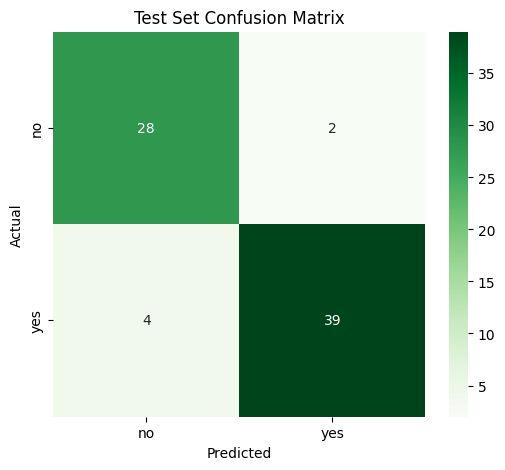

In [24]:
cm_test = confusion_matrix(y_test_true, y_test_pred_classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Greens", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Test Set Confusion Matrix")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


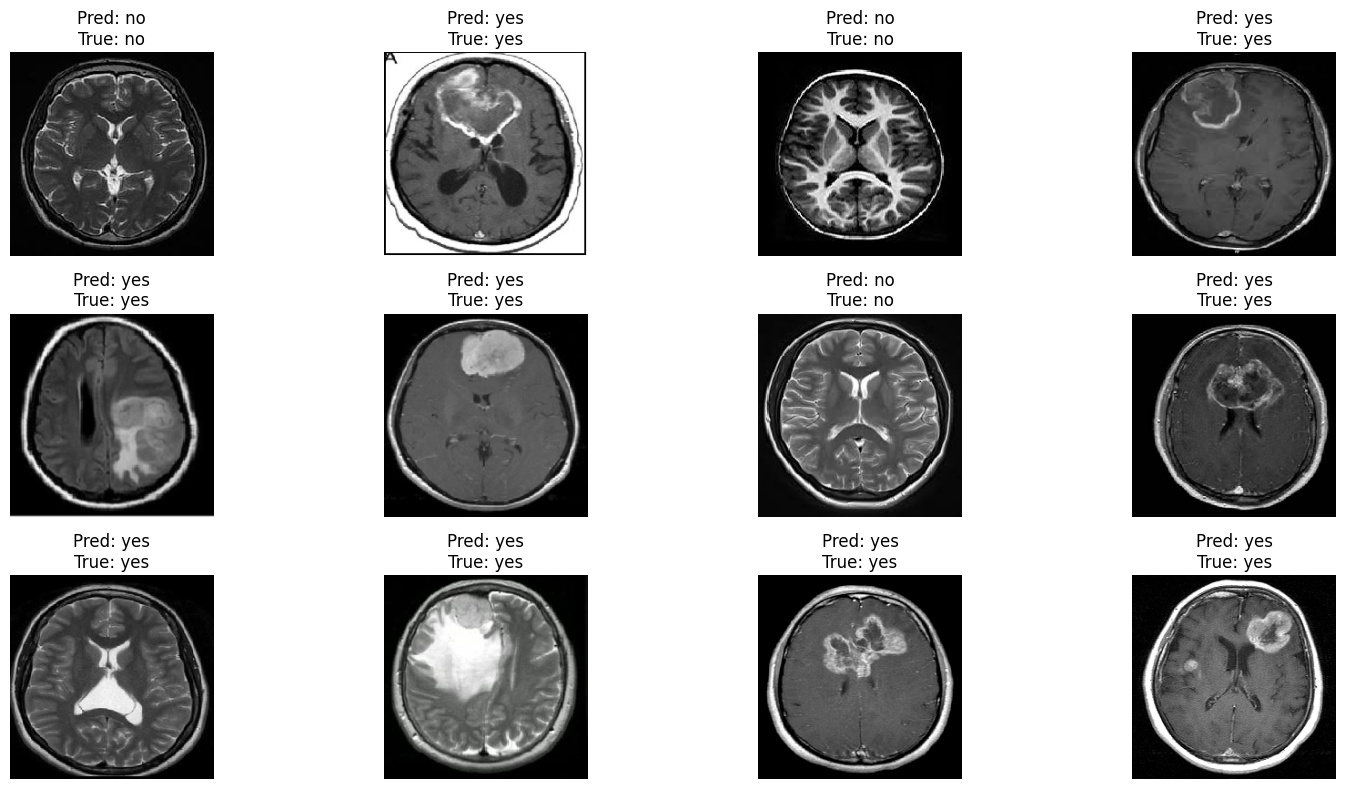

In [ ]:
# Test on samples
num_images = 12

class_labels = list(test_generator.class_indices.keys())

plt.figure(figsize=(16, 8))

indices = np.random.choice(len(test_generator), size=num_images, replace=False)

for i, idx in enumerate(indices):
    img, label = test_generator[idx]
    img_display = img[0]
    true_class = np.argmax(label[0])

    pred = model.predict(img)
    pred_class = np.argmax(pred[0])

    plt.subplot(3, 4, i+1)
    plt.imshow(img_display)
    plt.axis('off')
    plt.title(f"Pred: {class_labels[pred_class]}\nTrue: {class_labels[true_class]}")

plt.tight_layout()
plt.show()
